# Investigating Species at Risk Observations Within Canadian National Parks

In [1]:
import geopandas as gpd
import contextily as cx
from pygbif import occurrences
import pandas as pd

Load the dataset below. This reads data regarding National parks in Canada.

  CLAB_ID CPC_CODE REG_CODE CLAB_TYPE ABS_ACCUR  \
0    TORN       NL     None        NP      <10m   
1   33245       ON     None        NP       <2m   
2    WATE       AB     None        NP       <2m   
3    FIVE       ON     None        NP       <2m   
4    QAUS       NU     None        NP     >100m   

                                       NAME_E  \
0   TORNGAT MOUNTAINS NATIONAL PARK OF CANADA   
1                   ROUGE NATIONAL URBAN PARK   
2      WATERTON LAKES NATIONAL PARK OF CANADA   
3  FATHOM FIVE NATIONAL MARINE PARK OF CANADA   
4          QAUSUITTUQ NATIONAL PARK OF CANADA   

                                      NAME_F CLAB_CAT  \
0  PARC NATIONAL DES MONTS-TORNGAT DU CANADA       PA   
1           PARC URBAIN NATIONAL DE LA ROUGE       PA   
2  PARC NATIONAL DES LACS-WATERTON DU CANADA       PA   
3  PARC MARIN NATIONAL DU CANADA FATHOM FIVE       PA   
4         PARC NATIONAL QAUSUITTUQ DU CANADA       PA   

                                            geometry  


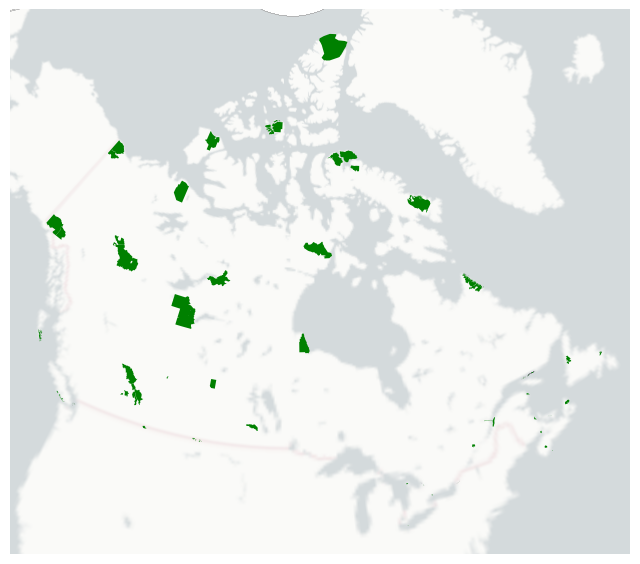

In [2]:
parks_gdf = gpd.read_file(r'data/parks_sar/parks.gpkg')

print(parks_gdf.head(5))

print(parks_gdf.crs)

ax = parks_gdf.plot(figsize=(8, 8), facecolor='green')
cx.add_basemap(ax, crs=parks_gdf.crs, source=cx.providers.CartoDB.PositronNoLabels, attribution="")
ax.set_axis_off()

Load the dataset below. It reads data regarding Canadian species at risk.

In [3]:
sar_df = pd.read_csv(r'data/parks_sar/CAN-SAR_database.csv')
print(sar_df.head(5))

   rowID  speciesID                                        common_name  \
0      2        394  allegheny mountain dusky salamander appalachia...   
1      3        396  allegheny mountain dusky salamander carolinian...   
2      4        396  allegheny mountain dusky salamander carolinian...   
3      6        367                                  american chestnut   
4      7        318                                   american columbo   

                    species                doc_type sara_status  \
0  Desmognathus ochrophaeus  COSEWIC Status Reports  Threatened   
1  Desmognathus ochrophaeus  COSEWIC Status Reports  Endangered   
2  Desmognathus ochrophaeus     Recovery Strategies  Endangered   
3          Castanea dentata     Recovery Strategies  Endangered   
4     Frasera caroliniensis     Recovery Strategies  Endangered   

                                        doc_citation  \
0  COSEWIC. 2018. COSEWIC assessment and status r...   
1  COSEWIC. 2018. COSEWIC assessment and

Let's print out the `parks_gdf` dataframe to get a better sense of its structure and the data it contains.

In [4]:
print(parks_gdf['NAME_E'].sort_values())

14                      AULAVIK NATIONAL PARK OF CANADA
8                     AUYUITTUQ NATIONAL PARK OF CANADA
44                        BANFF NATIONAL PARK OF CANADA
37        CAPE BRETON HIGHLANDS NATIONAL PARK OF CANADA
26                   ELK ISLAND NATIONAL PARK OF CANADA
3            FATHOM FIVE NATIONAL MARINE PARK OF CANADA
11                     FORILLON NATIONAL PARK OF CANADA
15                        FUNDY NATIONAL PARK OF CANADA
42         GEORGIAN BAY ISLANDS NATIONAL PARK OF CANADA
41                      GLACIER NATIONAL PARK OF CANADA
43                   GRASSLANDS NATIONAL PARK OF CANADA
39                   GROS MORNE NATIONAL PARK OF CANADA
17         GULF ISLANDS NATIONAL PARK RESERVE OF CANADA
9          GWAII HAANAS NATIONAL PARK RESERVE OF CANADA
32                      IVVAVIK NATIONAL PARK OF CANADA
28                       JASPER NATIONAL PARK OF CANADA
23                   KEJIMKUJIK NATIONAL PARK OF CANADA
34                       KLUANE NATIONAL PARK OF

The code below retrieves all GBIF occurrence records for a target species in Canada and plots them on top of a parks map to visualize where that species has been observed. Try experimenting with different `TARGET_SP`s

Total records downloaded: 300
Total records downloaded: 600
Total records downloaded: 900


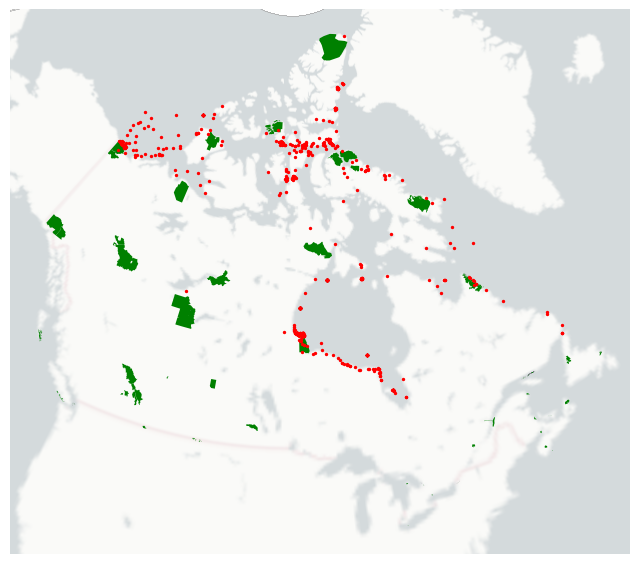

In [ ]:
# Based on code from https://discourse.gbif.org/t/retrieving-inaturalist-observations-for-a-region-observers-with-pygbif/4565

# NOTE: if many records are expected, downloading may take a very long time and code may need to be adjusted accordingly

# TARGET_SP = 'Salix turnorii' # Turnor's willow 
# TARGET_SP = 'Aneides vagrans' # wandering salamander
TARGET_SP = 'Ursus maritimus' # polar bear

results = []

offset = 0

while True:

    out = occurrences.search(scientificName=TARGET_SP,
                             country='CA',
                             hasCoordinate=True, 
                             hasGeospatialIssue=False, 
                             offset=offset
                            ) 
    
    if len(out['results']) == 0:
        break

    results.extend(out['results'])

    offset += len(results)

    print(f"Total records downloaded: {len(results)}")

lat_ls = [results[i]['decimalLatitude'] for i in range(len(results))]
lon_ls = [results[i]['decimalLongitude'] for i in range(len(results))]

occurences_gdf = (gpd.GeoDataFrame(geometry=gpd.points_from_xy(lon_ls, lat_ls), crs='EPSG:4326')
                  .to_crs(parks_gdf.crs))

ax = parks_gdf.plot(figsize=(8, 8), facecolor='green')
occurences_gdf.plot(ax=ax, color='red', markersize=2)
cx.add_basemap(ax, crs=parks_gdf.crs, source=cx.providers.CartoDB.PositronNoLabels, attribution="")
ax.set_axis_off()